In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import data_preprocessing as dp
import utilities
import models.training as train
from models.autoencoder import ConvolutionalAutoencoder

In [2]:
data, events = dp.load_data()

In [3]:
data, events = dp.choose_condition(data, events, 'inner speech')
data = data.astype(np.float16) * 100_000  # NORMALIZATION ONLY POSSIBLE BY MULTIPLYING HERE?
data = dp.normalization(data)

autoencoder_dataset = tf.data.Dataset.from_tensor_slices((data, data))
autoencoder_dataset = dp.preprocessing_pipeline(
    autoencoder_dataset,
    functions = [dp.filter_interval,
                 lambda sample: (tf.reshape(sample[0], (128, 640, 1)),
                                 tf.reshape(sample[0], (128, 640, 1)))
                ],
    args = [[[1, 3.5], 256, [0, 1]], []],
    batch_size = 12
)
autoencoder_datasets = dp.split_dataset(autoencoder_dataset,
                                        splits={'train':0.9,
                                                'test':0.05,
                                                'valid':0.05})

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-04 22:54:52.029948: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-04 22:54:52.030134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-04 22:54:57.797759: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "convolutional_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2123      
                                                                 
 decoder (Decoder)           multiple                  4001      
                                                                 
Total params: 6,124
Trainable params: 6,124
Non-trainable params: 0
_________________________________________________________________


2022-03-04 22:55:04.330935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


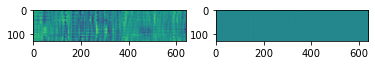

In [4]:
autoencoder = ConvolutionalAutoencoder()
autoencoder.build((None, 128,640,1))

autoencoder.summary()

for _input, target in autoencoder_datasets['train'].take(1):
    out = autoencoder(_input)
    plt.subplot(1,2,1)
    plt.imshow(target[0][:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(out[0][:,:,0])

In [5]:
%matplotlib tk
# Initialize the loss-function
loss_func = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()
# Initialize Train-Object
trainer = train.Trainer(autoencoder, autoencoder_datasets, optimizer, loss_func)
# Initialize Plotting-Object
grapher = utilities.TrainingGrapher(2,1, supxlabel='Epochs', axs_xlabels=[['train loss', 'test loss']])

for epoch in range(20):
    print(epoch, end='\r')  
    trainer.train_epoch()
    grapher.update([trainer.losses['train'], trainer.losses['test']])


2022-03-04 22:55:06.510966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 22:55:06.725700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/lld/Documents/inner_speech_decoding/utilities.py:77: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  self.axs[i%self.plot_shape[1], i//self.plot_shape[0]].set_xlim(min(xd), max(xd))


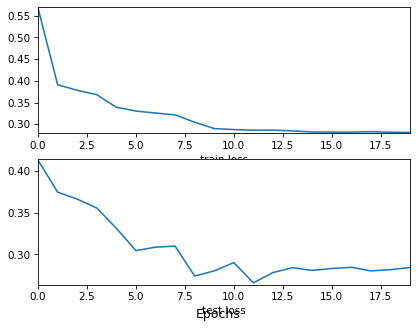

In [6]:
%matplotlib inline
grapher.fig

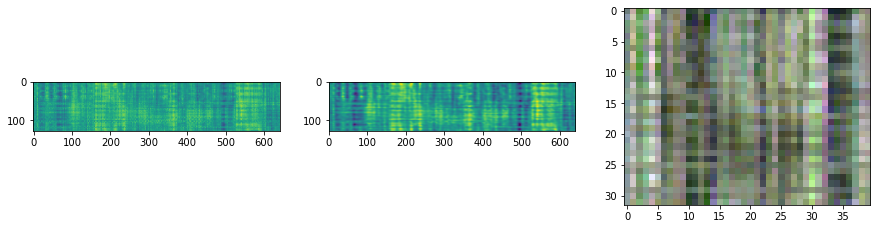

In [7]:
for i, t in autoencoder_datasets['valid'].take(1):
    out_enc = autoencoder.encoder(i)
    out_dec = autoencoder.decoder(out_enc)
    f, axs = plt.subplots(1,3,figsize=(15,15))
    axs[0].imshow(t[0][:,:,0])
    axs[1].imshow(out_dec[0][:,:,0])
    # normalize each channel
    norm_enc = out_enc[0] / np.max(out_enc[0], (0, 1))[np.newaxis, np.newaxis, :]
    axs[2].imshow(norm_enc)

In [8]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
autoencoder.save('./models/saved_models/autoencoder')

2022-03-04 22:58:29.129134: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/saved_models/autoencoder/assets
